# Example 3. Basic Linear regression with *SkLearn*
---
### Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston()

In [2]:
df =  pd.DataFrame( data=boston.data )
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
X = df[['RM']].values
y = df[['MEDV']].values # Add more [] to avoid getting WARNING in standardization

In [4]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return

---
### *Single-expanatory variable* linear regression model (typical case)
**1\. Using *sklearn* package** 
<br />Use single explanatory variable **RM**, which has linear correlation with target variable **MEDV**, to fit with linear regression model by *sklearn* class.

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
slr = LinearRegression()
slr.fit(X, y)
print 'Slop: %.3f'% slr.coef_[0]
print 'Intercept: %.3f'% slr.intercept_

Slop: 9.102
Intercept: -34.671


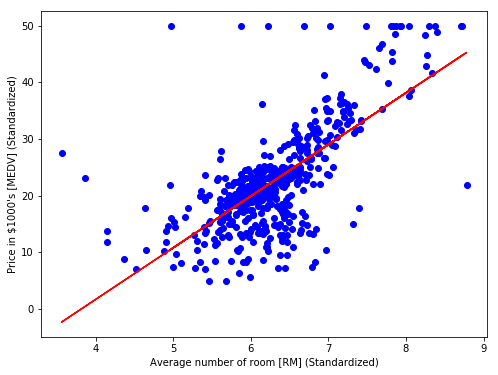

In [7]:
plt.figure(figsize=(8,6))
lin_regplot(X, y, slr)
plt.xlabel('Average number of room [RM] (Standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (Standardized)' )
plt.show()

In [8]:
# The input 5 is the same with hand-made results.
print slr.predict([[5.0]])[0,0]

10.8399241295


The result is similar to handmade case in [Example 2.](http://localhost:8888/notebooks/Python_ML_SR/Chapter_10/example_02_LinearRegressionGD.ipynb). The prediction is the same. The fitting looks can describle partial behavior of data. For instance, there are some top-line data which are not in the fit.

**2\. Analytical way to sovle the single variable case**
$$
\begin{equation}
\begin{split}
y &= w_0X_0 + w_1x_1 \\
& = wX \\
\end{split}
\end{equation}
$$

where $w_0$ are 0 in standardized data, $X_1$ is the only explanatory variable witn $N$ dimesion. To find solution of $w_1$, the $X$ can be move as  

$$
\begin{equation}
\begin{split}
y &= w_1X \\
X^{T}y &= w_1X X^{T} \\
\end{split}
\end{equation}
$$

We create a squarde matrix with $X^TX$ for transfer to $I$ in $w_1$ term. The solution of $w_1$ will be
$$w_1 = (X^TX)^{-1}X^{T}y\ .$$ 

The method can be easily applied by *Numpy* python package.

In [9]:
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[0])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))
print 'Slope: %.3f' % w[1]
print 'Intercept: %.3f' % w[0]

Slope: 9.102
Intercept: -34.671


---
### Random sample consensus (RANSAC)
The algorithm is for assembling the regressions with ***inliers*** sample iterativily. Here we input the linear regression model. The algorithm with use the random 50 samples to make a first regression model. In the next iteration, it will include other 50 samples, which are fitted with previous model with particular residual threshold, to make a new model for next iteration. Those samples are so called ***inliers*** samples. The process will be finished until all inlier samples are included, or the trials are up to the maximum setting, here is 100.  

In [10]:
from sklearn.linear_model import RANSACRegressor

In [11]:
ransac = RANSACRegressor( LinearRegression(), 
                          max_trials=100, min_samples=50, 
                          #residual_matric=lambda dy: np.sum(np.abs(dy), axis=1),
                          residual_threshold = 5.0,
                          random_state=0 )
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [12]:
inlier_mask = ransac.inlier_mask_
outier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict( line_X[:, np.newaxis] )

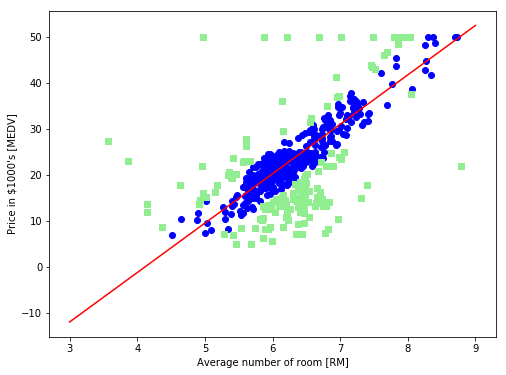

In [13]:
plt.figure(figsize=(8,6))
plt.scatter( X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliner')
plt.scatter( X[outier_mask], y[outier_mask], c='lightgreen', marker='s', label='Outier')
plt.plot( line_X, line_y_ransac, color='red')
plt.xlabel('Average number of room [RM]')
plt.ylabel('Price in $1000\'s [MEDV]' )
plt.show()

The results shows many outier samples, green dots, are surround the fitting line, which means the fitter can not completily to describe the data. 

---
### *Multi-explanatory variables* linear regression & *score* the results
1. Input with all variables linear regressor for building a fitting hyperplane.
2. No need to standardization, since the regression is for predicting a continue value.
3. The hyperplane can not be visulized, the alternative way is showing the residure v.s. predict value, where residure is target - prediction. 

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Use all variables
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_predict = slr.predict(X_train)
y_test_predict = slr.predict(X_test)

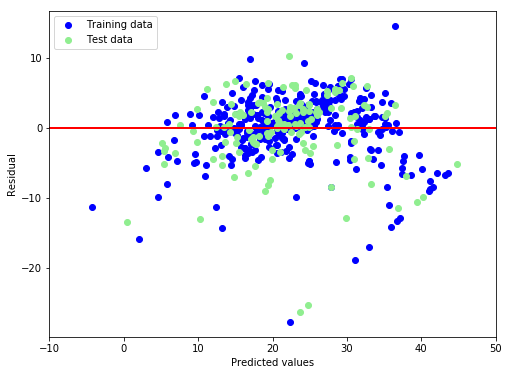

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(y_train_predict, y_train_predict - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_predict, y_test_predict - y_test, c='lightgreen', marker='o', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.legend(loc='upper left')
plt.hlines( y=0, xmin=-10, xmax=50, lw=2, color='red' )
plt.xlim([-10, 50])
plt.show()

Most of sample are surround within 0 line, which means they are fitted with model. But there are many samples are far from line. They can not be discribe well with linear regression model.

** Score results **
1. By ***mean squared error*** (MSE), which is defined as $$\frac{1}{n}\sum_{i=1}^{n}{(y_{i} - \hat{y}_{i})^2}\ ,$$<br /> where $y_{i}$ is target value, and $\hat{y}_{i}$ is predict value from the $i$ sample. The total number of samples is $N$. The more less gain, the prediction is more fit with target.
2. The alternative way is using ***coefficient of determination*** ($\,R^2$), which is the value to determine the variant of model. The defination is using ***sum squared error*** (SSE) and ***sum squared total variation*** (SST) as $$
\begin{equation}
\begin{split}
R^2 &=1-\frac{SSE}{SST} \\ 
&= 1 - \frac{\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}}{\sum_{i=1}^{n}{(y_i-\mu_y)^2}} \\
&= 1 - \frac{\frac{1}{N}\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2}}{\frac{1}{N}\sum_{i=1}^{n}{(y_i-\mu_y)^2}} \\
&= 1 - \frac{MSE}{Var(y)}\ ,
\end{split}
\end{equation}
$$<br /> where $\mu_y$ is the average of $y$. Thus, when $R^2$ is closs to 1, the model has good fit performance, i.e. MSE is close to 0, while $R^2=0$ means the bad fitting. 

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
print 'Train MSE: %.3f, R2: %.3f'%( mean_squared_error(y_train, y_train_predict), r2_score(y_train, y_train_predict) )
print 'MSE test:  %.3f, R2: %.3f' %( mean_squared_error(y_test,  y_test_predict),  r2_score(y_test,  y_test_predict) )

Train MSE: 19.966, R2: 0.764
MSE test:  27.184, R2: 0.674


Apparently we got overfitted model....